In [1]:
#prepare the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("ivv_normal.csv")
df['ret'] = df['close'].pct_change()
df.head()

,Unnamed: 0,date,low,high,close,volume,open,close-open,close-open_%of_close,high-low,high-low_%of_close,macd,rsi,50d_avg,100d_avg,200d_avg,so,ret
0,200,20010307,-0.439921,-0.455396,126.55,-0.669027,-0.438876,-0.124481,-0.119906,-0.293656,-0.254819,-1.713257,-0.062340,-0.328303,-0.265805,-0.107318,-0.765715,NaN
1,201,20010308,-0.429719,-0.447085,126.92,-1.015534,-0.439084,0.174580,0.180720,-0.327246,-0.289116,-1.572642,0.318968,-0.330083,-0.267201,-0.108762,-0.303249,0.002924
2,202,20010309,-0.494888,-0.480540,123.47,-0.244510,-0.468421,-1.430906,-1.471366,0.240059,0.297527,-1.636192,-0.013111,-0.333621,-0.270195,-0.110353,-1.609645,-0.027182
3,203,20010312,-0.609195,-0.550982,117.78,-0.285677,-0.534586,-3.406283,-3.679961,1.023836,1.177954,-1.982363,-0.009977,-0.340270,-0.274561,-0.112813,-1.609645,-0.046084
4,204,20010313,-0.615233,-0.596905,119.72,-1.009871,-0.601999,0.670392,0.718906,0.307240,0.396222,-2.125731,-0.012221,-0.346038,-0.277851,-0.114912,-1.036723,0.016471


In [2]:
df.columns

Index(['Unnamed: 0', 'date', 'low', 'high', 'close', 'volume', 'open',
       'close-open', 'close-open_%of_close', 'high-low', 'high-low_%of_close',
       'macd', 'rsi', '50d_avg', '100d_avg', '200d_avg', 'so', 'ret'],
      dtype='object')

In [3]:
#first, use 3000-day training and 1400-day testing
#note that since the model is predicting future returns, there is a mismatch in time which is handled here
#choose only the following columns
df_sample = df[['volume','macd', 'rsi', '50d_avg', '100d_avg', '200d_avg', 'so']][:-1]
X = df_sample
Y = df['ret'].loc[1:]
len(X) == len(Y)

True

In [4]:
#split the training and testing data
X_train = X.head(3000)
y_train = Y.head(3000)

X_test = X.loc[3000:]
y_test = Y.loc[3001:]
len(X_test) ==len(y_test)

True

In [20]:
print(len(X_train),len(X_test))

3000 1356


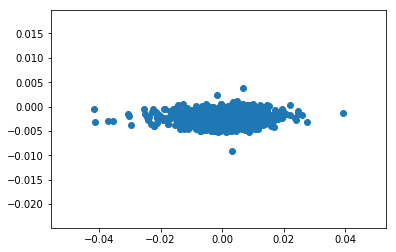

In [6]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_test_hat)

In [7]:
#if price indeed evolves as predicted, what will it be
#plot against what actually happened
df_comp = pd.DataFrame(data=y_test_hat+1, columns=['predicted_growth_rate'])
df_comp['actual_growth_rate'] = y_test.reset_index()['ret']+1
start_val = df['close'][3000]

df_comp['predicted_val'] = 1
df_comp['actual_val'] = df['close'][3001:].reset_index(drop=True)

df_comp['predicted_val'][0] = df_comp['actual_val'][0]


for i in range(1, len(df_comp)):
    df_comp['predicted_val'][i] = df_comp['predicted_val'][i-1] * df_comp['predicted_growth_rate'][i-1]



/home/shiyun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/shiyun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


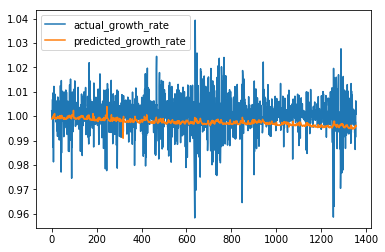

In [8]:
df_comp[['actual_growth_rate','predicted_growth_rate']].plot()

In [9]:
df_train_comp = pd.DataFrame(data=y_train_hat+1, columns=['training_predicted_growth'])
df_train_comp['training_actual_growth'] = pd.DataFrame(data=np.asarray(y_train+1), columns=['training_actual_growth'])

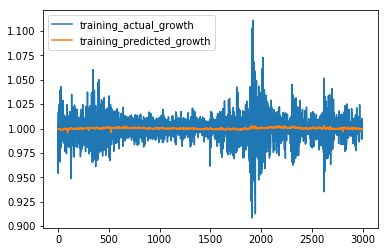

In [10]:
df_train_comp[['training_actual_growth','training_predicted_growth']].plot()

### Check whether the assumption for linear regression holds

In [11]:
#calculate the residuals
#check whether residuals are normally distributed
import statsmodels.api as sm
res_train = y_train - y_train_hat
res_test = y_test - y_test_hat

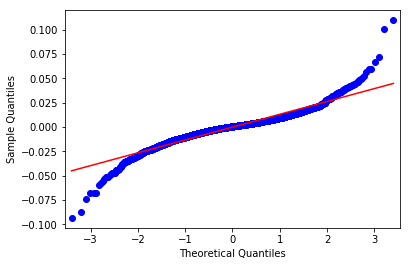

In [12]:
probplot = sm.ProbPlot(res_train)
fig = probplot.qqplot(line='s')
plt.show()

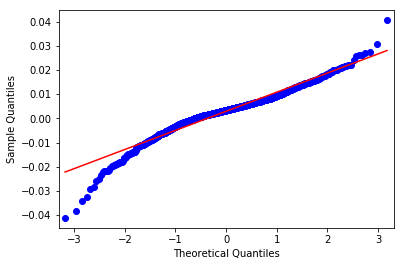

In [13]:
probplot = sm.ProbPlot(res_test)
fig = probplot.qqplot(line='s')
plt.show()

In [14]:
from scipy import stats
x = np.asarray(y_train)
test_stat = stats.kstest(x, 'norm')
test_stat

KstestResult(statistic=0.47732895965482447, pvalue=0.0)

In [15]:
x2 = np.asarray(y_train_hat)
test_stat = stats.kstest(x2, 'norm')
test_stat

KstestResult(statistic=0.4989517310016187, pvalue=0.0)

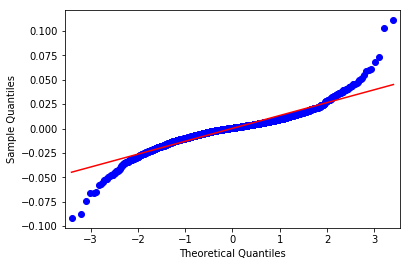

In [16]:
import statsmodels.api as sm
probplot = sm.ProbPlot(x)
fig = probplot.qqplot(line='s')
plt.show()

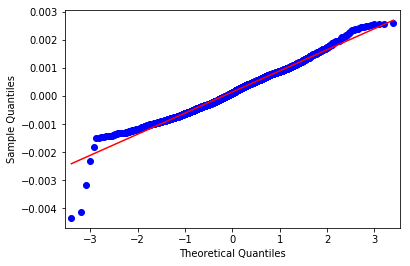

In [17]:
probplot = sm.ProbPlot(x2)
fig = probplot.qqplot(line='s')
plt.show()

### Calculate accuracy rate for the test

In [18]:
df_comp['y_test'] = df_comp['actual_growth_rate'] - 1
df_comp['y_test_hat'] = df_comp['predicted_growth_rate'] - 1
df_comp['direction_correct'] = np.where(df_comp['y_test'] * df_comp['y_test_hat'] >0, 1,0)
direction_correct_rate = df_comp['direction_correct'].sum()/len(df_comp)

In [19]:
direction_correct_rate

0.4609144542772861

In [34]:
res_test.to_csv("residual_test.csv", index=False)
res_train.to_csv("residual_train.csv")